In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')

# 根据共同分布生成关键点位置
from utils.keyloc_generate import generate_key_locs
import utils.TbdGeo as TbdGeo


In [2]:
#Life pattern
lifepattern = pd.read_csv('Lifepattern/Lifepattern.csv')

#Key location
H_prob = pd.read_csv(r'Keylocation/H_prob.csv')
HW_prob = pd.read_csv(r'Keylocation/HW_prob.csv')
HO_prob = pd.read_csv(r'Keylocation/HO_prob.csv')
WO_prob = pd.read_csv(r'Keylocation/WO_prob.csv')

In [28]:
lifepattern

,reindex,type,hour,count,otype,dtype
0,4999,H_0.O_7,22,1,H_0,O_7
1,4999,O_9.O_5,17,1,O_9,O_5
2,4999,O_9.O_3,8,1,O_9,O_3
3,4999,O_9.O_2,13,1,O_9,O_2
4,4999,O_9.O_1,22,2,O_9,O_1
...,...,...,...,...,...,...
878838,4999,O_9.O_9,16,1,O_9,O_9
878839,4999,O_9.O_9,17,1,O_9,O_9
878840,4999,O_9.O_9,20,1,O_9,O_9
878841,4999,O_9.O_9,21,2,O_9,O_9


In [27]:
HW_prob

,hgrid,hlon,hlat,wgrid,wlon,wlat,T_ij
0,"-1,10",120.86875,30.795830,"-1,7",120.86875,30.770831,2
1,"-1,52",120.86875,31.145816,"0,59",120.88125,31.204147,2
2,"-1,66",120.86875,31.262478,"5,83",120.94375,31.404139,2
3,"-1,74",120.86875,31.329142,"6,79",120.95625,31.370807,2
4,"-1,79",120.86875,31.370807,"35,59",121.31875,31.204147,2
...,...,...,...,...,...,...,...
328059,"9,83",120.99375,31.404139,"10,74",121.00625,31.329142,2
328060,"9,84",120.99375,31.412472,"14,79",121.05625,31.370807,3
328061,"9,84",120.99375,31.412472,"7,82",120.96875,31.395806,2
328062,"9,85",120.99375,31.420805,"39,66",121.36875,31.262478,2


In [29]:
def generate_traj(days,seed):
    #设置不同的random seed
    np.random.seed(seed)
    traj = TbdGeo.generate_seq(lifepattern[lifepattern['reindex'] == lifepattern['reindex'].sample(1).iloc[0]],days = days,seq_type = 'df',starttime='2023-07-12')

    key_loc = generate_key_locs(H_prob,HO_prob,HW_prob,WO_prob)
    key_loc = pd.DataFrame(key_loc).T.reset_index()
    key_loc.columns = ['type','lat','lon']

    traj = pd.merge(traj,key_loc,on='type',how='left')
    return traj


In [30]:
lifepattern[lifepattern['reindex'] == lifepattern['reindex'].sample(1).iloc[0]]

,reindex,type,hour,count,otype,dtype
40675,4062,H_0.H_0,15,1,H_0,H_0
40676,4062,O_9.O_4,8,1,O_9,O_4
40677,4062,O_9.H_0,22,1,O_9,H_0
40678,4062,O_9.H_0,8,2,O_9,H_0
40679,4062,O_8.H_0,22,1,O_8,H_0
...,...,...,...,...,...,...
755679,4062,O_9.O_9,8,3,O_9,O_9
755680,4062,O_9.O_9,19,1,O_9,O_9
755681,4062,O_9.O_9,20,1,O_9,O_9
755682,4062,O_9.O_9,21,1,O_9,O_9


In [4]:
N = 10
days = 7
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
g = pd.DataFrame(range(N))[0].parallel_apply(lambda x:generate_traj(days,seed = x))
def reid_traj(x):
    uid = x['index']
    traj = x[0]
    traj['uid'] = uid
    return traj
g = pd.concat(list(g.reset_index().apply(lambda x:reid_traj(x),axis=1)))

g.to_csv(f'result/synthetic_data_{N}.csv',index=None)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [13]:
g

,time,type,lat,lon,uid
0,2023-07-12 00:06:00,H_0,31.217311,121.491205,0
1,2023-07-12 10:24:00,W_0,31.197233,121.538826,0
2,2023-07-12 22:36:19,H_0,31.217311,121.491205,0
3,2023-07-13 08:56:29,W_0,31.197233,121.538826,0
4,2023-07-13 23:52:02,H_0,31.217311,121.491205,0
...,...,...,...,...,...
11,2023-07-17 07:08:16,W_0,31.195608,121.518668,9
12,2023-07-17 21:53:10,O_5,31.002538,121.540897,9
13,2023-07-18 07:07:31,O_1,31.157649,121.509614,9
14,2023-07-18 08:54:04,W_0,31.195608,121.518668,9


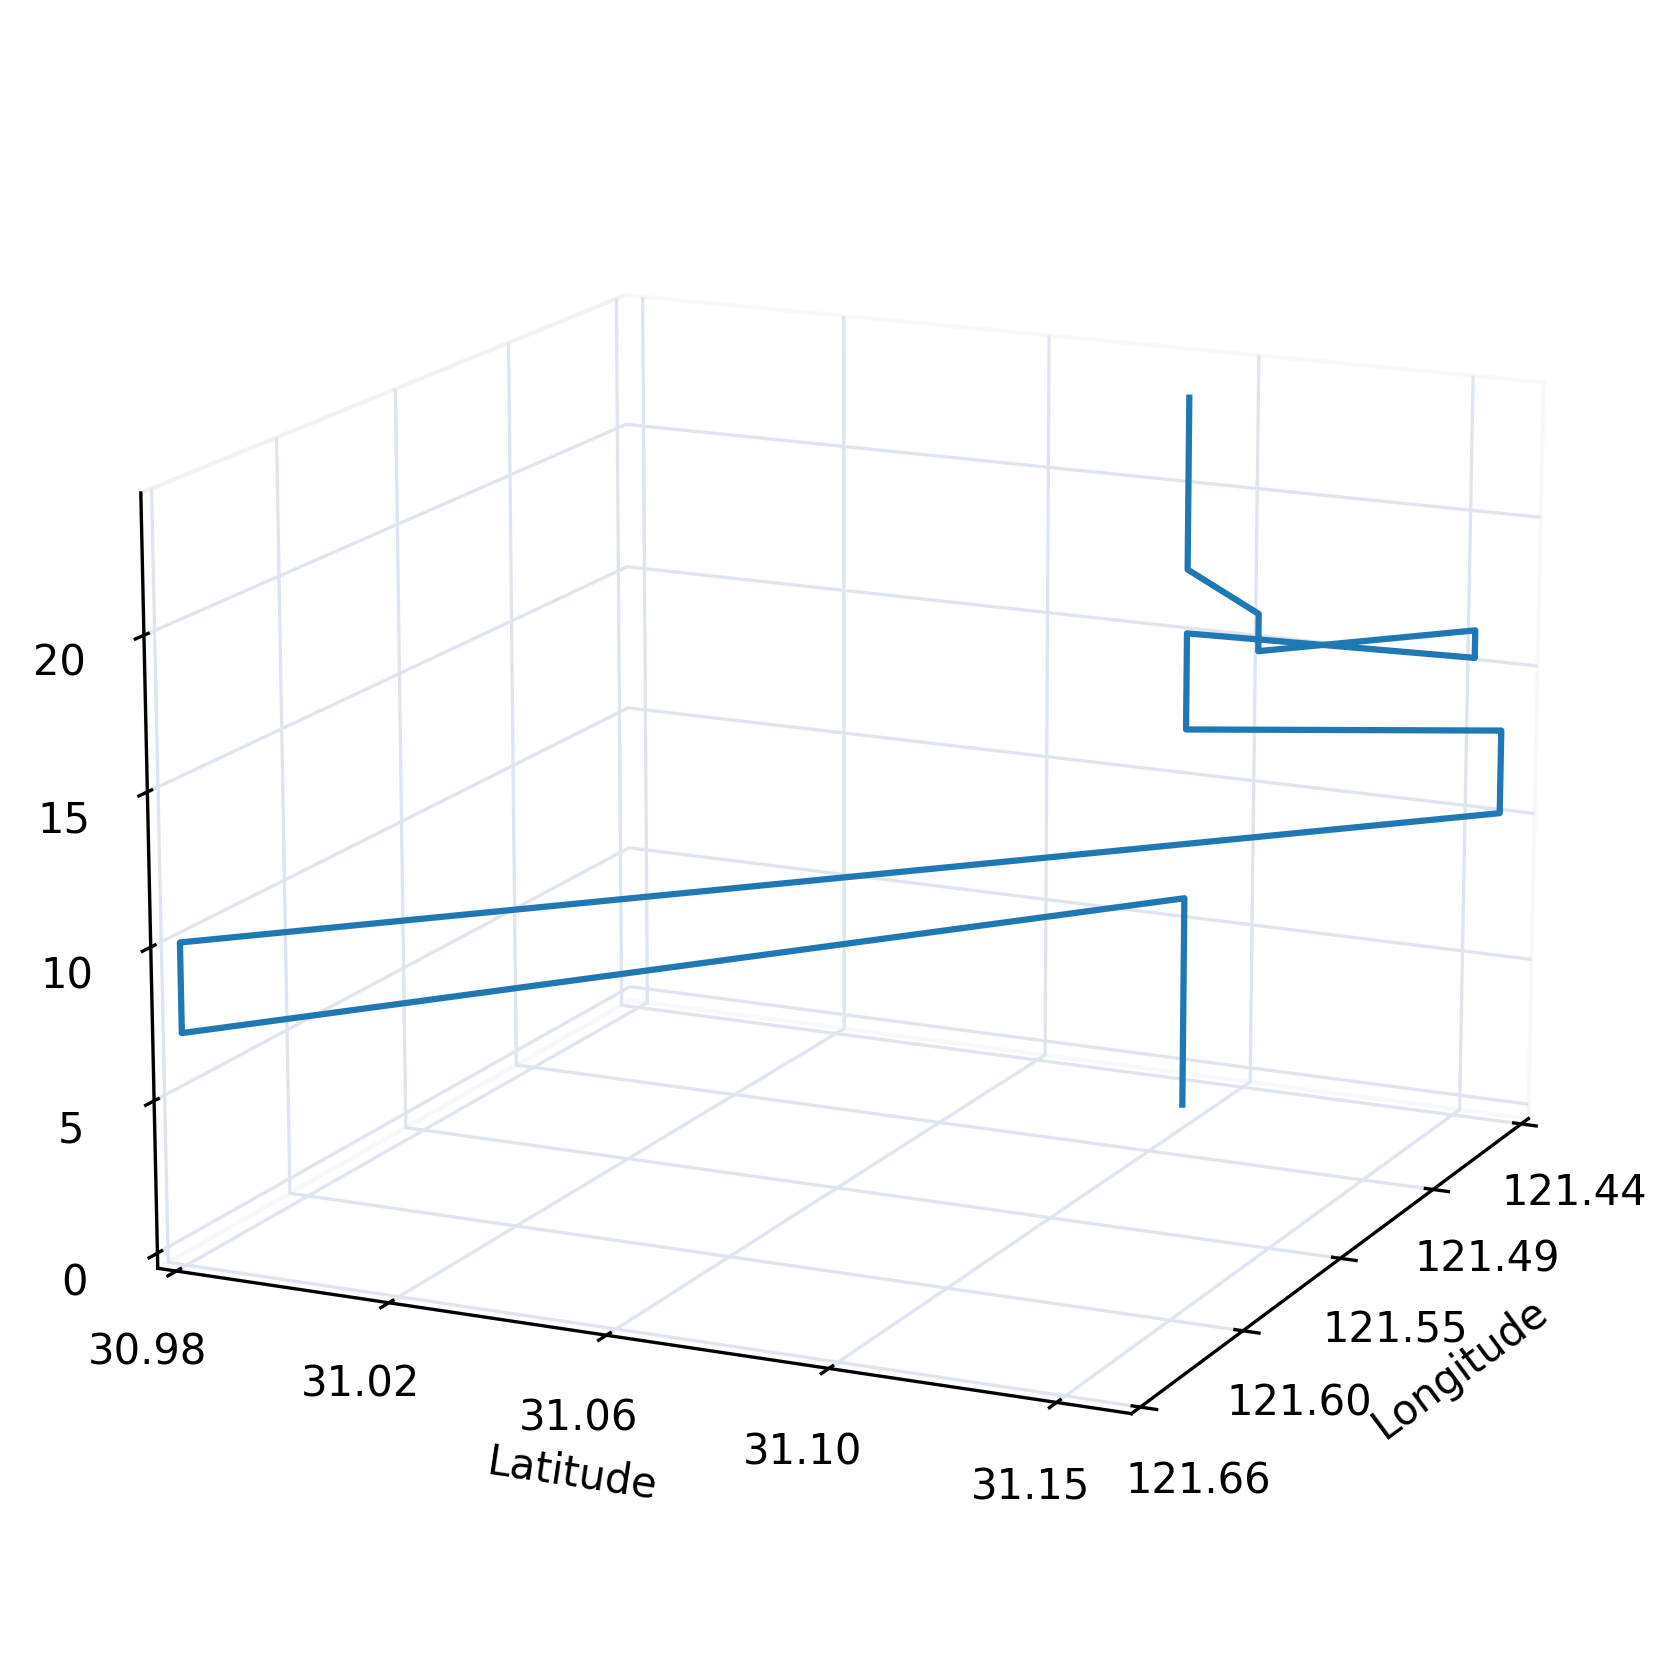

In [25]:
#单一条轨迹可视化
#用于mobmap可视化的数据导出

import utils.plot_traj as plot_traj
plot_traj.plot_traj(g[g['uid']==g['uid'].drop_duplicates().sample(1).iloc[0]],
                    starttime='2023-07-12 00:00:00'
                    ,days = 1,fix = 2)